SET UP DATASET VIA KAGGLE API

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shanegerami/ai-vs-human-text

 97% 340M/350M [00:03<00:00, 95.2MB/s]
100% 350M/350M [00:03<00:00, 104MB/s] 


In [ ]:
!unzip ai-vs-human-text.zip

Archive:  ai-vs-human-text.zip
  inflating: AI_Human.csv            


SET UP THE ENVIRONNEMENT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
dataset = pd.read_csv("/content/AI_Human.csv")
dataset.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [ ]:
dataset.tail()

,text,generated
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0
487234,"Richard Non, Jimmy Carter, and Bob Dole and ot...",0.0


-*Observation*:
we could observe that the dataset is shuffle.

In [ ]:
dataset[dataset["generated"] == 1].count()

text         181438
generated    181438
dtype: int64

In [ ]:
dataset[dataset["generated"] == 0].count()

text         305797
generated    305797
dtype: int64

-*Observation*:

There is double data that are generated by human than AI.

I think that because of this that the system can be biased.

In [ ]:
dataset['length'] = dataset['text'].apply(len)

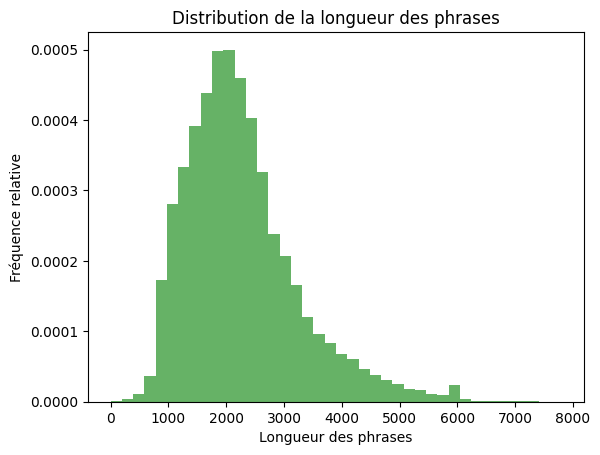

In [ ]:
plt.hist(dataset['length'], bins=40, density=True, alpha=0.6, color='g',  range=(0, 7800))


plt.title('Distribution de la longueur des phrases')
plt.xlabel('Longueur des phrases')
plt.ylabel('Fréquence relative')
plt.show()

In [ ]:
length_counts = dataset["length"].value_counts()
print(length_counts)


1974    320
1942    303
2082    303
1855    302
2048    296
       ... 
555       1
8436      1
5236      1
6117      1
6320      1
Name: length, Length: 6419, dtype: int64


-Observation:

I think that i will limited the AI model to 1974 words. Rectification i don't have enough ressources for runninig up to 1974 words.

In [ ]:
dataset.count()

text         487235
generated    487235
length       487235
dtype: int64

In [ ]:
dataset_human = dataset[dataset['generated']==0]
dataset_ai = dataset[dataset['generated']==1]

In [ ]:
limit_text = 60000
percentage_text = int(60000*70/100)

In [ ]:
from sklearn.utils import shuffle


x_human = shuffle(dataset_human["text"][0:limit_text], random_state= 42)
x_ai = shuffle(dataset_ai["text"][0:limit_text], random_state= 42)
y_human = shuffle(dataset_human["generated"][0:limit_text], random_state = 42)
y_ai = shuffle(dataset_ai["generated"][0:limit_text], random_state = 42)

In [ ]:
y_ai.head()

28723    1.0
76203    1.0
79914    1.0
24620    1.0
24374    1.0
Name: generated, dtype: float64

In [ ]:
y_human.head()

13664    0.0
70679    0.0
81138    0.0
9561     0.0
9315     0.0
Name: generated, dtype: float64

In [ ]:
x_human.count()

60000

In [ ]:
x_ai.count()

60000

In [ ]:


x_train = pd.concat([x_human[0:percentage_text],x_ai[0:percentage_text]], ignore_index = True)
x_test = pd.concat([x_human[percentage_text:],x_ai[percentage_text:]], ignore_index = True)
y_train = pd.concat([y_human[0:percentage_text],y_ai[0:percentage_text]], ignore_index = True)
y_test = pd.concat([y_human[percentage_text:],y_ai[percentage_text:]], ignore_index = True)

random_seed = 42


combined_data_train = pd.concat([x_train, y_train], axis=1)
combined_data_test = pd.concat([x_test,y_test], axis = 1)

# Shuffle the combined DataFrame
shuffled_data_train = shuffle(combined_data_train, random_state=random_seed)
shuffled_data_test = shuffle(combined_data_test, random_state=random_seed)

# Splitting into training and testing sets
x_train = shuffled_data_train["text"]
y_train = shuffled_data_train["generated"]
x_test = shuffled_data_test["text"]
y_test = shuffled_data_test["generated"]

In [ ]:
y_train.value_counts()

0.0    42000
1.0    42000
Name: generated, dtype: int64

In [ ]:
y_test.value_counts()

0.0    18000
1.0    18000
Name: generated, dtype: int64


vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = ""
training_size = 20000

In [ ]:
#parameters
max_len_words = 1000
nums_words = 10000

In [ ]:
tokenizer = Tokenizer(num_words=nums_words, oov_token = "<OOV>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [ ]:
print(word_index)

{'<OOV>': 1, 'the': 2, 'to': 3, 'and': 4, 'a': 5, 'of': 6, 'in': 7, 'that': 8, 'is': 9, 'it': 10, 'for': 11, 'be': 12, 'can': 13, 'you': 14, 'are': 15, 'they': 16, 'on': 17, 'have': 18, 'this': 19, 'i': 20, 'not': 21, 'their': 22, 'with': 23, 'as': 24, 'or': 25, 'students': 26, 'people': 27, 'more': 28, 'we': 29, 'by': 30, 'would': 31, 'if': 32, 'will': 33, 'but': 34, 'because': 35, 'also': 36, 'car': 37, 'from': 38, 'an': 39, 'there': 40, 'cars': 41, 'do': 42, 'has': 43, 'our': 44, 'school': 45, 'electoral': 46, 'could': 47, 'like': 48, 'when': 49, 'one': 50, 'your': 51, 'them': 52, 'all': 53, 'help': 54, 'about': 55, 'time': 56, 'should': 57, 'college': 58, 'was': 59, 'some': 60, 'at': 61, 'make': 62, 'so': 63, 'who': 64, 'what': 65, 'may': 66, 'many': 67, 'other': 68, 'get': 69, 'these': 70, 'just': 71, 'while': 72, 'which': 73, 'venus': 74, 'states': 75, 'life': 76, 'face': 77, 'vote': 78, 'how': 79, 'my': 80, 'work': 81, 'system': 82, 'think': 83, 'way': 84, 'even': 85, 'than': 86

In [ ]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen = max_len_words,
                                padding = "post", truncating = "post")
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, maxlen = max_len_words,
                                padding = "post", truncating = "post")

In [ ]:
print(test_padded)

[[ 60  27  83 ...   0   0   0]
 [115  41  15 ...   0   0   0]
 [ 20 118   8 ...   0   0   0]
 ...
 [ 45   9   2 ...   0   0   0]
 [ 88   6 100 ...   0   0   0]
 [ 20 602  83 ...   0   0   0]]


In [ ]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

#reset

optimizer = Adam(learning_rate=0.0005)
model = 0
# Définir les paramètres pour overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
num_epochs = 30

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(nums_words, 32, input_length = max_len_words),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(8, activation="relu" ),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1,activation = "sigmoid")
])


model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])

training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(test_padded)
testing_labels = np.array(y_test)

history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    batch_size = 16,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stopping], verbose=2)

Epoch 1/30
5250/5250 - 33s - loss: 0.5527 - accuracy: 0.8250 - val_loss: 0.2393 - val_accuracy: 0.9670 - 33s/epoch - 6ms/step
Epoch 2/30
5250/5250 - 33s - loss: 0.3736 - accuracy: 0.8684 - val_loss: 0.1739 - val_accuracy: 0.9911 - 33s/epoch - 6ms/step
Epoch 3/30
5250/5250 - 32s - loss: 0.3647 - accuracy: 0.8675 - val_loss: 0.1597 - val_accuracy: 0.9927 - 32s/epoch - 6ms/step
Epoch 4/30
5250/5250 - 32s - loss: 0.3618 - accuracy: 0.8669 - val_loss: 0.1597 - val_accuracy: 0.9933 - 32s/epoch - 6ms/step
Epoch 5/30
5250/5250 - 29s - loss: 0.3585 - accuracy: 0.8685 - val_loss: 0.1596 - val_accuracy: 0.9933 - 29s/epoch - 5ms/step
Epoch 6/30
5250/5250 - 32s - loss: 0.3581 - accuracy: 0.8673 - val_loss: 0.1609 - val_accuracy: 0.9921 - 32s/epoch - 6ms/step
Epoch 7/30
5250/5250 - 29s - loss: 0.3566 - accuracy: 0.8671 - val_loss: 0.1625 - val_accuracy: 0.9898 - 29s/epoch - 6ms/step
Epoch 8/30
5250/5250 - 33s - loss: 0.3512 - accuracy: 0.8698 - val_loss: 0.1508 - val_accuracy: 0.9946 - 33s/epoch - 6

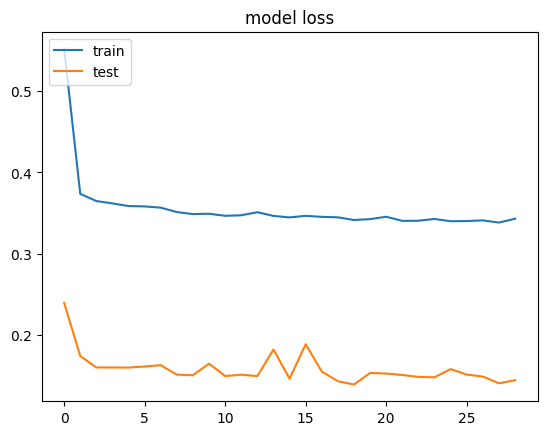

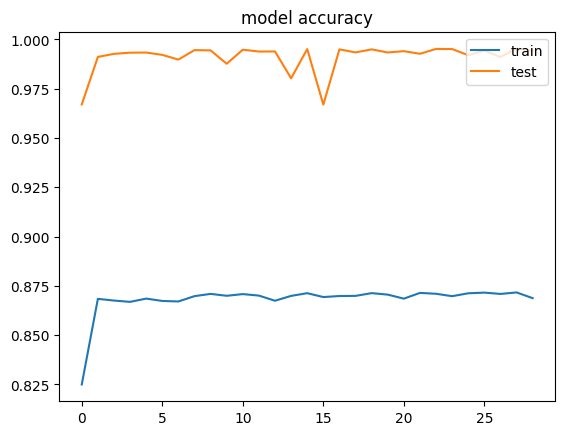

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "test"], loc="upper left")
plt.title("model loss")
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train", "test"], loc="upper right")
plt.title("model accuracy")
plt.show()


In [ ]:
x_human_test = dataset_human["text"][100000:140000]
x_ai_test = dataset_ai["text"][100000:140000]
y_human_test = dataset_human["generated"][100000:140000]
y_ai_test = dataset_ai["generated"][100000:140000]

In [ ]:
x_human_test.head()

171169    Many lives today has been taken away by those ...
171170    Dear TEACHER_NAME:\n\nI think that students sh...
171173    The Facial Action Coding System is a new cover...
171174    In the first source It's explain what an Elect...
171175    The meaning of a democracy is that the people ...
Name: text, dtype: object

In [ ]:
y_human_test.head()

171169    0.0
171170    0.0
171173    0.0
171174    0.0
171175    0.0
Name: generated, dtype: float64

In [ ]:
# Concatenate and shuffle the test set
x_test = pd.concat([x_human_test, x_ai_test], ignore_index=True)
y_test = pd.concat([y_human_test, y_ai_test], ignore_index=True)

combined_data_test = pd.concat([x_test, y_test], axis=1)

# Shuffle the combined DataFrame
shuffled_data_test = shuffle(combined_data_test, random_state=random_seed)

# Reset index to ensure that column titles are preserved
shuffled_data_test.reset_index(drop=True, inplace=True)

x_shuffled_test = shuffled_data_test.iloc[:, 0]
y_shuffled_test = shuffled_data_test.iloc[:, 1]

# Tokenize and pad the test data
sequences_test = tokenizer.texts_to_sequences(x_shuffled_test.astype("str"))
padded_test = pad_sequences(sequences_test, maxlen=max_len_words, padding="post", truncating="post")

# Evaluate the model on the test set
loss, accuracy = model.evaluate(padded_test, y_shuffled_test)

# Print the results
print("Loss:", loss)
print("Accuracy:", accuracy)


2500/2500 [==============================] - 7s 3ms/step - loss: 0.1480 - accuracy: 0.9919
Loss: 0.1479826420545578
Accuracy: 0.9919000267982483


In [65]:
x_test = pd.concat([x_human_test,x_ai_test], ignore_index= True)
y_test = pd.concat([y_human_test, y_ai_test], ignore_index=True)

combined_data_test = pd.concat([x_test, y_test], axis=1)

# Shuffle the combined DataFrame
shuffled_data_test = shuffle(combined_data_test, random_state=random_seed)

# Reset index to ensure that column titles are preserved
shuffled_data_test.reset_index(drop=True, inplace=True)

x_shuffled_test = shuffled_data_test.iloc[:, 0]
y_shuffled_test = shuffled_data_test.iloc[:, 1]
sequences_test = tokenizer.texts_to_sequences(x_shuffled_test.astype("str"))

padded_test = pad_sequences(sequences_test, maxlen = max_len_words,padding = "post",truncating = "post")
loss, accuracy = model.evaluate(padded_test, y_shuffled_test)

# Affichez les résultats (par exemple, la perte et la précision)
print("Loss:", loss)
print("accuracy:", accuracy)

2500/2500 [==============================] - 6s 2ms/step - loss: 0.1480 - accuracy: 0.9919
Loss: 0.1479826420545578
accuracy: 0.9919000267982483


In [ ]:
x_test = pd.concat([x_human_test, x_ai_test], ignore_index=True)
y_test = pd.concat([y_human_test, y_ai_test], ignore_index=True)

combined_data_test = pd.concat([x_test, y_test], axis=1)

# Shuffle the combined DataFrame
shuffled_data_test = shuffle(combined_data_test, random_state=random_seed)

# Reset index to ensure that column titles are preserved
shuffled_data_test.reset_index(drop=True, inplace=True)

x_shuffled_test = shuffled_data_test.iloc[:, 0]
y_shuffled_test = shuffled_data_test.iloc[:, 1]

# Tokenize and pad the test data
sequences_test = tokenizer.texts_to_sequences(x_shuffled_test.astype("str"))
padded_test = pad_sequences(sequences_test, maxlen=max_len_words, padding="post", truncating="post")

# Evaluate the model on the test set
loss, accuracy = model.evaluate(padded_test, y_shuffled_test)

# Print the results
print("Loss:", loss)
print("accuracy:", accuracy)


2500/2500 [==============================] - 6s 2ms/step - loss: 0.1480 - accuracy: 0.9919
Loss: 0.1479826420545578
accuracy: 0.9919000267982483
